# Data Cleaning: Transactions

In [69]:
import os

import joblib
import numpy as np
import pandas as pd
import skops.io as sio
from tqdm import tqdm
import matplotlib.pyplot as plt

from helpers import (
    CHARTS_DIR, OUTLIER_MODEL_DIR, ENCODER_MODEL_DIR, TRANSFORMED_DATA_DIR
)

import plotly.express as px

In [70]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt1.parquet')
df_transactions

,township,spa_date,address,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price
0,BANDAR BARU SRI PETALING,2023-06-09,"✕✕✕, JALAN PIKRAMA",TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1,nan,"2,196 ft²",nan,342,"750,000"
1,BANDAR BARU SRI PETALING,2023-06-01,"✕✕. ✕✕, JALAN PERLAK 3",TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,nan,753 ft²,nan,398,"300,000"
2,BANDAR BARU SRI PETALING,2023-05-29,"✕✕ ✕, JALAN 12/149L",TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2½,nan,"3,197 ft²",nan,188,"600,000"
3,BANDAR BARU SRI PETALING,2023-05-25,"✕✕. ✕✕✕, JALAN PASAI",TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,nan,753 ft²,nan,531,"400,000"
4,BANDAR BARU SRI PETALING,2023-05-22,"✕✕, JALAN SRI PETALING 5",SEMI-D,LEASEHOLD,2½,nan,"4,801 ft²",nan,250,"1,200,000"
...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,"✕✕✕-✕✕✕, BB WANGSA MAJU",FLAT,LEASEHOLD,1,2,493 ft²,493 ft²,71,"35,000"
294563,IDAMAN PUTERI,2005-01-10,"✕✕-✕, JALAN GOMBAK",CONDOMINIUM,FREEHOLD,1,3,1454 ft²,1454 ft²,150,"218,025"
294564,KELAB LE CHATEAU II,2008-02-25,"✕-✕✕-✕, JALAN KIARA 3",CONDOMINIUM,FREEHOLD,1,3,593 ft²,593 ft²,194,"115,000"
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,"✕-✕-✕, OFF JALAN SENTUL",APARTMENT,LEASEHOLD,1,2,1193 ft²,1193 ft²,197,"235,000"


In [71]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294567 entries, 0 to 294566
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   township       294567 non-null  object        
 1   spa_date       294567 non-null  datetime64[ns]
 2   address        294546 non-null  object        
 3   building_type  294567 non-null  object        
 4   tenure         294567 non-null  object        
 5   floors         294567 non-null  object        
 6   rooms          294567 non-null  object        
 7   land_area      294567 non-null  object        
 8   built_up       294567 non-null  object        
 9   price_psf      294567 non-null  object        
 10  price          294567 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 24.7+ MB


### Concluding Remarks from Data Exploration: Recap
1. How does each dataset look like? Is it in row format or it has merged cells?
    - It is in row format, with no merged cells.
2. What is the start and end of each dataset?
    - From 1909 to 2023
3. Is the dataset from the area of interest, Kuala Lumpur?
    - Yes
4. How is the data quality?
    - There are missing values in some columns (`built_up` and `rooms`). Need to decide to remove rows or impute.
    - Values in some columns (`land_area` and `built_up`) has unit of measurement like "ft2". Need to remove.
    - Values in `floors` column uses fraction instead of decimal. Need to change.
    - Values in numerical columns (`land_area`, `built_up`, `price_psf` and `price`) has comma. Need to remove.
    - Some values in some columns (`floors` and `rooms`) does not make sense. Need further investigation.
    - Only landed properties are in the dataset. Need another round of scraping for high rise real estate.

## Preparation

Selection:
1. Drop `address` column
2. Split `spa_date` to `year`, `month` and `day`

Cleaning:
1. Change fraction in `floors` column, i.e. 1/2 to .5
2. Remove comma in `price_psf`
3. Remove comma in `price`
4. Remove comma and ft2 in `land_area` and `built_up`
5. Remove 'acre' in `land_area` and convert into sqft
6. Investigate missing values in `built_up` and remove/impute
7. For `rooms` column:
    - Investigate missing values in `rooms` and remove/impute
    - Investigate weird `rooms` values (0 and 46) and remove/impute
8. Investigate weird `floors` values (0 and 99) and remove/impute

### Remove address column

In [72]:
# Removing address column
df_transactions = df_transactions.drop(columns=['address'])
df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1,nan,"2,196 ft²",nan,342,"750,000"
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,nan,753 ft²,nan,398,"300,000"
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2½,nan,"3,197 ft²",nan,188,"600,000"
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,nan,753 ft²,nan,531,"400,000"
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2½,nan,"4,801 ft²",nan,250,"1,200,000"
...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1,2,493 ft²,493 ft²,71,"35,000"
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1,3,1454 ft²,1454 ft²,150,"218,025"
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1,3,593 ft²,593 ft²,194,"115,000"
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1,2,1193 ft²,1193 ft²,197,"235,000"


In [73]:
df_transactions['year'] = df_transactions['spa_date'].dt.year
df_transactions['month'] = df_transactions['spa_date'].dt.month
df_transactions['day'] = df_transactions['spa_date'].dt.day

df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294567 entries, 0 to 294566
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   township       294567 non-null  object        
 1   spa_date       294567 non-null  datetime64[ns]
 2   building_type  294567 non-null  object        
 3   tenure         294567 non-null  object        
 4   floors         294567 non-null  object        
 5   rooms          294567 non-null  object        
 6   land_area      294567 non-null  object        
 7   built_up       294567 non-null  object        
 8   price_psf      294567 non-null  object        
 9   price          294567 non-null  object        
 10  year           294567 non-null  int32         
 11  month          294567 non-null  int32         
 12  day            294567 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(9)
memory usage: 25.8+ MB


### Change fraction to decimal

In [74]:
# Change fraction to decimal
from helpers import convert_mixed_fraction_to_decimal

df_transactions['floors'] = df_transactions['floors'].apply(lambda x: convert_mixed_fraction_to_decimal(x))
df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1,nan,"2,196 ft²",nan,342,"750,000",2023,6,9
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,nan,753 ft²,nan,398,"300,000",2023,6,1
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,nan,"3,197 ft²",nan,188,"600,000",2023,5,29
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,nan,753 ft²,nan,531,"400,000",2023,5,25
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,nan,"4,801 ft²",nan,250,"1,200,000",2023,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1,2,493 ft²,493 ft²,71,"35,000",1990,11,13
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1,3,1454 ft²,1454 ft²,150,"218,025",2005,1,10
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1,3,593 ft²,593 ft²,194,"115,000",2008,2,25
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1,2,1193 ft²,1193 ft²,197,"235,000",2009,8,10


### Remove commas

In [75]:
# Change nan to NaN to ease processing
df_transactions = df_transactions.replace('nan', np.nan)
df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1,NaN,"2,196 ft²",NaN,342,"750,000",2023,6,9
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753 ft²,NaN,398,"300,000",2023,6,1
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,NaN,"3,197 ft²",NaN,188,"600,000",2023,5,29
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753 ft²,NaN,531,"400,000",2023,5,25
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,NaN,"4,801 ft²",NaN,250,"1,200,000",2023,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1,2,493 ft²,493 ft²,71,"35,000",1990,11,13
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1,3,1454 ft²,1454 ft²,150,"218,025",2005,1,10
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1,3,593 ft²,593 ft²,194,"115,000",2008,2,25
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1,2,1193 ft²,1193 ft²,197,"235,000",2009,8,10


In [76]:
# Remove commas from numeric columns
columns_with_comma = ['price_psf', 'price', 'land_area', 'built_up', 'rooms']

for column in columns_with_comma:
    df_transactions[column] = df_transactions[column].apply(
        lambda x: x if pd.isna(x) else x.replace(',', '')
    )

df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1,NaN,2196 ft²,NaN,342,750000,2023,6,9
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753 ft²,NaN,398,300000,2023,6,1
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,NaN,3197 ft²,NaN,188,600000,2023,5,29
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753 ft²,NaN,531,400000,2023,5,25
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,NaN,4801 ft²,NaN,250,1200000,2023,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1,2,493 ft²,493 ft²,71,35000,1990,11,13
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1,3,1454 ft²,1454 ft²,150,218025,2005,1,10
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1,3,593 ft²,593 ft²,194,115000,2008,2,25
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1,2,1193 ft²,1193 ft²,197,235000,2009,8,10


### Remove units

In [77]:
# Remove units from numeric columns
columns_with_ft2 = ['land_area', 'built_up']

for column in columns_with_ft2:
    df_transactions[column] = df_transactions[column].apply(
        lambda x: x if pd.isna(x) else x.replace(' ft²', '')
    )

df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1,NaN,2196,NaN,342,750000,2023,6,9
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753,NaN,398,300000,2023,6,1
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,NaN,3197,NaN,188,600000,2023,5,29
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753,NaN,531,400000,2023,5,25
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,NaN,4801,NaN,250,1200000,2023,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1,2,493,493,71,35000,1990,11,13
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1,3,1454,1454,150,218025,2005,1,10
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1,3,593,593,194,115000,2008,2,25
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1,2,1193,1193,197,235000,2009,8,10


In [78]:
# Remove units from numeric columns
columns_with_acre = ['land_area', 'built_up']

for column in columns_with_acre:
    acre_index = df_transactions[df_transactions[column].apply(lambda x: not str(x).isdigit())].index
    df_transactions[column] = df_transactions[column].apply(
        lambda x: x if pd.isna(x) else x.replace(' acre', '')
    )
    df_transactions.loc[acre_index, column] = df_transactions.loc[acre_index, column].apply(
        lambda x: float(x) * 43560
    )

df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1,NaN,2196,NaN,342,750000,2023,6,9
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753,NaN,398,300000,2023,6,1
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,NaN,3197,NaN,188,600000,2023,5,29
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2,NaN,753,NaN,531,400000,2023,5,25
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,NaN,4801,NaN,250,1200000,2023,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1,2,493,493,71,35000,1990,11,13
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1,3,1454,1454,150,218025,2005,1,10
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1,3,593,593,194,115000,2008,2,25
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1,2,1193,1193,197,235000,2009,8,10


In [79]:
type_conversion = {
    'township': 'category',
    'building_type': 'category',
    'tenure': 'category',
    'floors': 'float',
    'rooms': 'float',
    'land_area': 'float',
    'built_up': 'float',
    'price_psf': 'float',
    'price': 'float'
}

for column, dtype in type_conversion.items():
    df_transactions[column] = df_transactions[column].astype(dtype)

df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294567 entries, 0 to 294566
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   township       294567 non-null  category      
 1   spa_date       294567 non-null  datetime64[ns]
 2   building_type  294567 non-null  category      
 3   tenure         294567 non-null  category      
 4   floors         294567 non-null  float64       
 5   rooms          263897 non-null  float64       
 6   land_area      294567 non-null  float64       
 7   built_up       288954 non-null  float64       
 8   price_psf      294567 non-null  float64       
 9   price          294567 non-null  float64       
 10  year           294567 non-null  int32         
 11  month          294567 non-null  int32         
 12  day            294567 non-null  int32         
dtypes: category(3), datetime64[ns](1), float64(6), int32(3)
memory usage: 20.3 MB


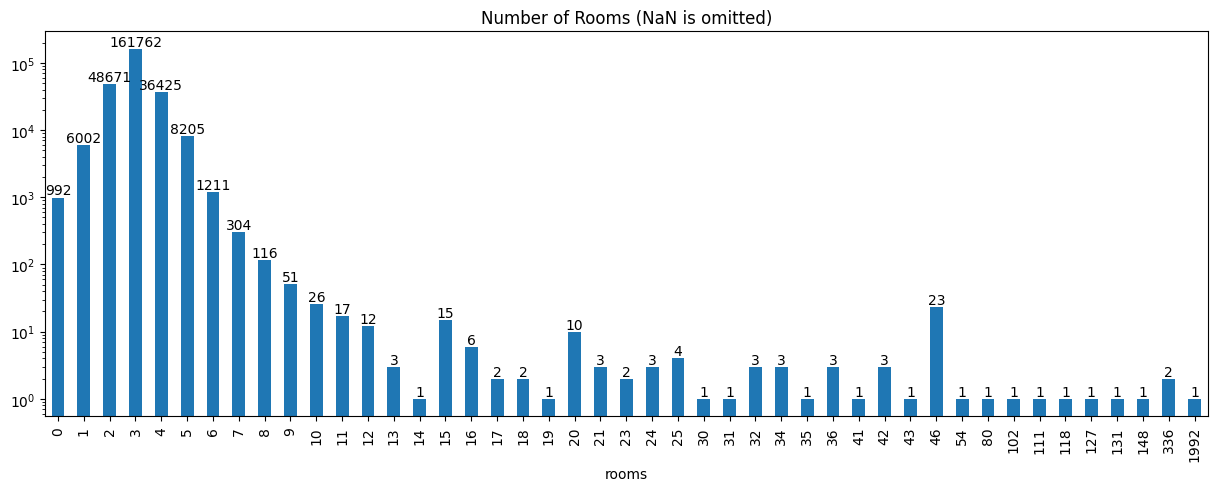

In [80]:
ax = df_transactions['rooms'].value_counts().sort_index().plot(
    kind='bar',
    logy=True,
    figsize=(15, 5),
    title='Number of Rooms (NaN is omitted)'
)
ax.bar_label(ax.containers[0], fmt='%.0f')
ax.set_xticklabels(df_transactions['rooms'].value_counts().sort_index().index.astype(int))
plt.show()

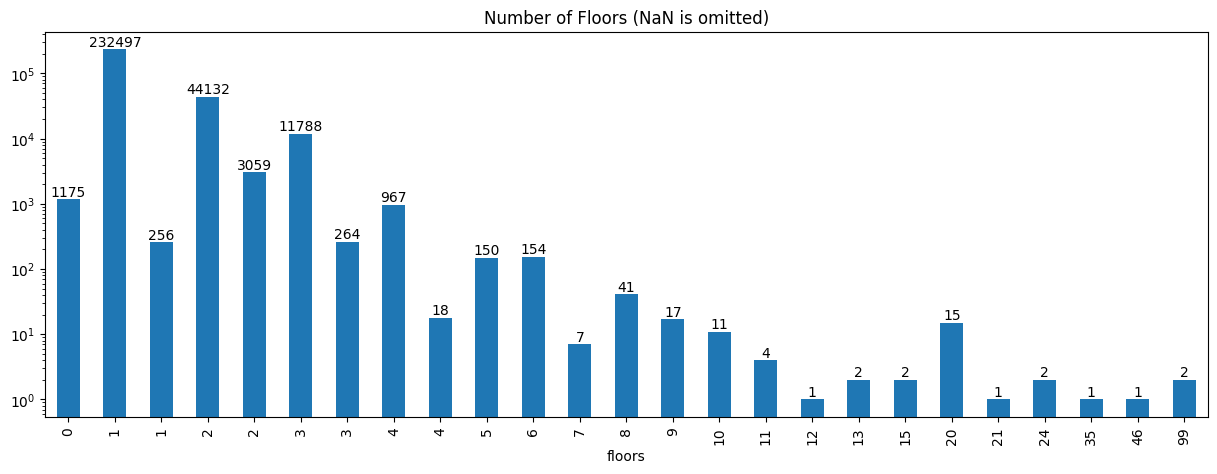

In [81]:
ax = df_transactions['floors'].value_counts().sort_index().plot(
    kind='bar',
    logy=True,
    figsize=(15, 5),
    title='Number of Floors (NaN is omitted)'
)
ax.bar_label(ax.containers[0], fmt='%.0f')
ax.set_xticklabels(df_transactions['floors'].value_counts().sort_index().index.astype(int))
plt.show()

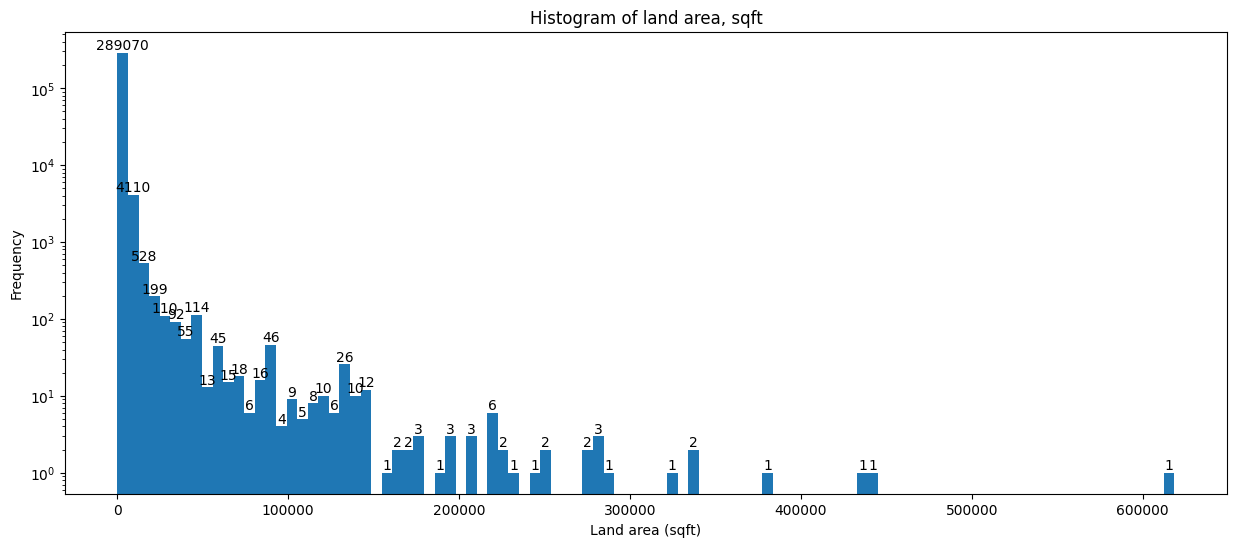

In [82]:
ax = df_transactions['land_area'].plot(
    kind='hist',
    bins=100,
    figsize=(15, 6),
    logy=True,
    title='Histogram of land area, sqft',
    xlabel='Land area (sqft)'
)
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

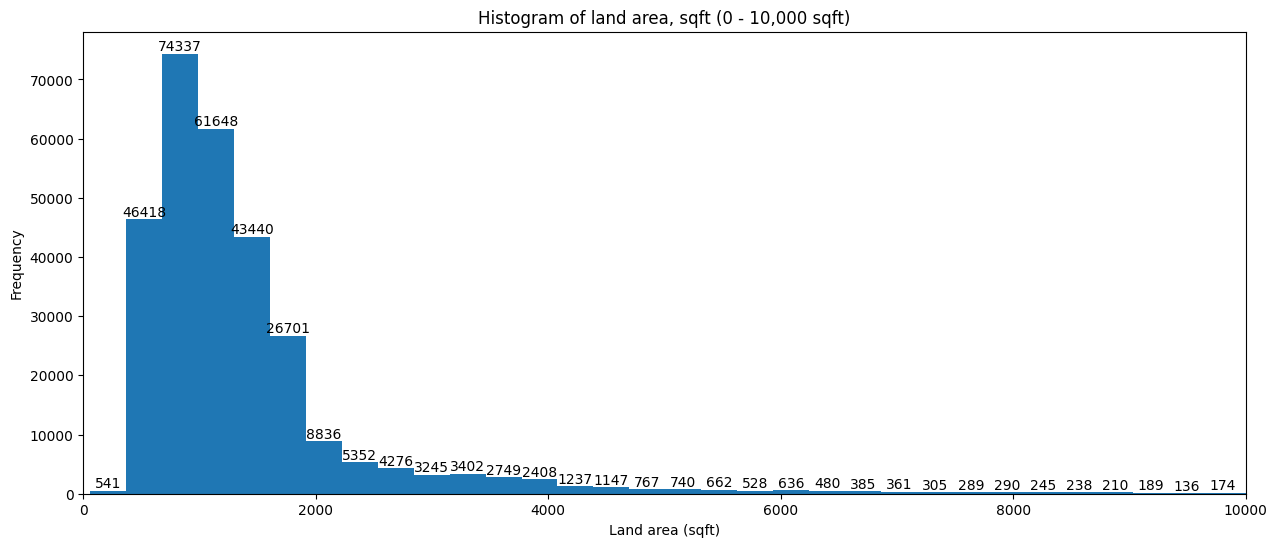

In [83]:
ax = df_transactions['land_area'].plot(
    kind='hist',
    xlim=(0, 10_000),
    bins=2000,
    figsize=(15, 6),
    # logy=True,
    title='Histogram of land area, sqft (0 - 10,000 sqft)',
    xlabel='Land area (sqft)',
)
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

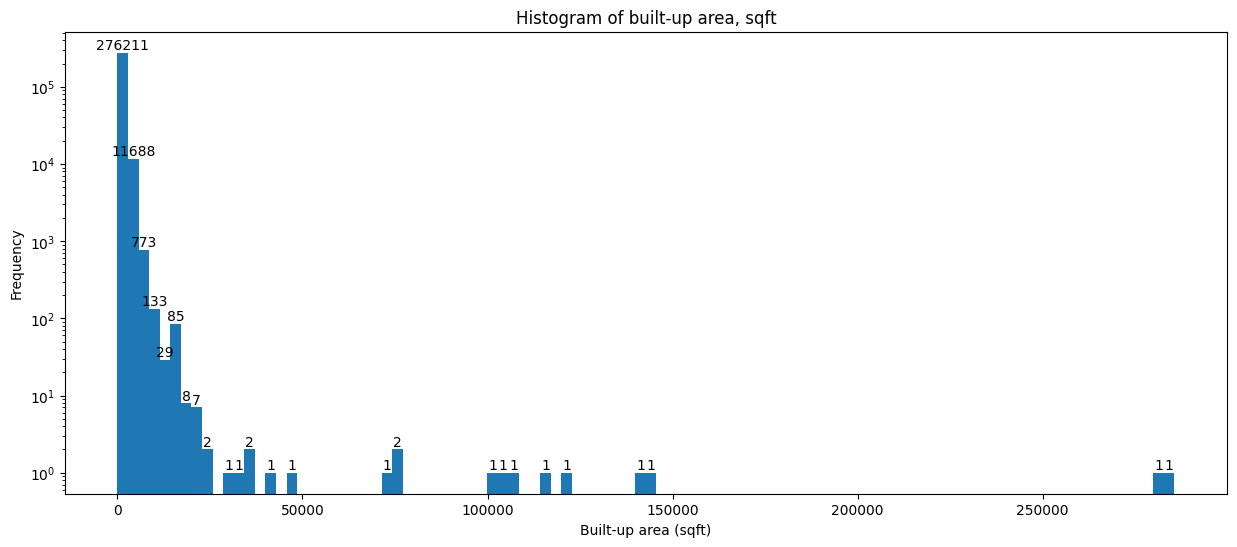

In [84]:
ax = df_transactions['built_up'].plot(
    kind='hist',
    bins=100,
    figsize=(15, 6),
    logy=True,
    title='Histogram of built-up area, sqft',
    xlabel='Built-up area (sqft)'
)
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

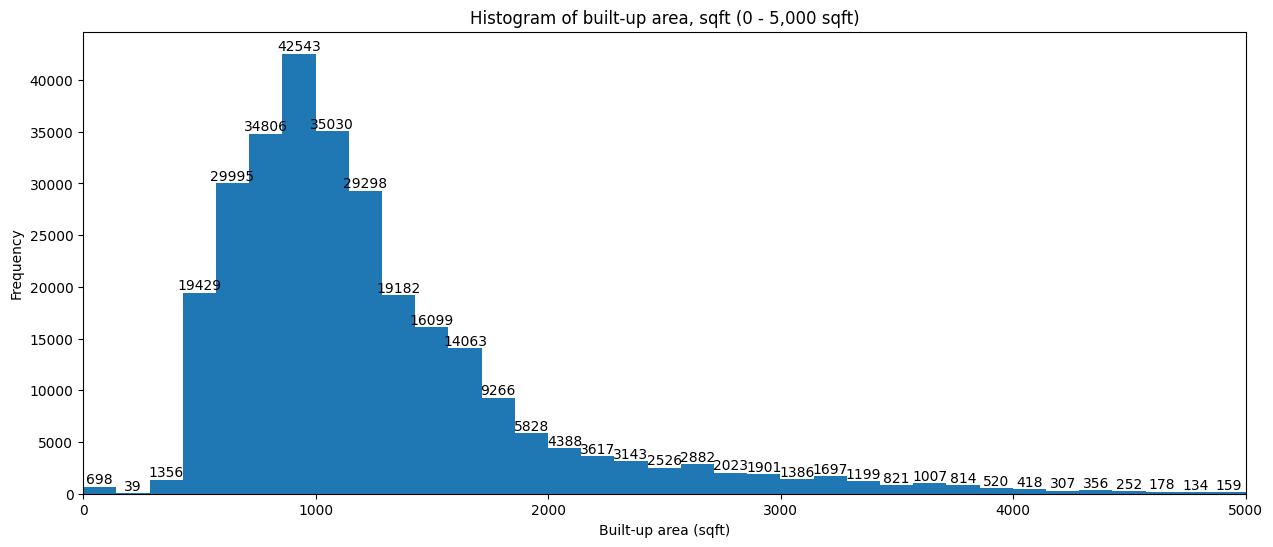

In [85]:
ax = df_transactions['built_up'].plot(
    kind='hist',
    xlim=(0, 5_000),
    bins=2000,
    figsize=(15, 6),
    # logy=True,
    title='Histogram of built-up area, sqft (0 - 5,000 sqft)',
    xlabel='Built-up area (sqft)',
)
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

## Investigate duplicates

We define duplicates as exact duplicates, where more than one transactions has all similar values in all columns.

In [12]:
df_transactions.duplicated().value_counts()

False    265294
True      29273
Name: count, dtype: int64

Based on the `df.duplicated()` method, there are 29,273 duplicates in the dataset.

In [28]:
df_duplicates = df_transactions[df_transactions.duplicated(keep=False)].sort_values(by=['township', 'spa_date'])
df_duplicates

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
256085,1 DESA RESIDENCE,2013-09-18,CONDOMINIUM,FREEHOLD,1.0,4.0,2142.0,2142.0,677.0,1450000.0,2013,9,18
256086,1 DESA RESIDENCE,2013-09-18,CONDOMINIUM,FREEHOLD,1.0,4.0,2142.0,2142.0,677.0,1450000.0,2013,9,18
256083,1 DESA RESIDENCE,2013-11-07,CONDOMINIUM,FREEHOLD,1.0,3.0,2146.0,2146.0,233.0,500000.0,2013,11,7
256084,1 DESA RESIDENCE,2013-11-07,CONDOMINIUM,FREEHOLD,1.0,3.0,2146.0,2146.0,233.0,500000.0,2013,11,7
256081,1 DESA RESIDENCE,2013-12-13,CONDOMINIUM,FREEHOLD,1.0,4.0,2141.0,2141.0,626.0,1340000.0,2013,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288500,ZETA DESKYE,2017-03-06,CONDOMINIUM,FREEHOLD,1.0,3.0,967.0,967.0,600.0,580000.0,2017,3,6
288497,ZETA DESKYE,2017-03-27,CONDOMINIUM,FREEHOLD,1.0,3.0,1270.0,1270.0,575.0,730000.0,2017,3,27
288498,ZETA DESKYE,2017-03-27,CONDOMINIUM,FREEHOLD,1.0,3.0,1270.0,1270.0,575.0,730000.0,2017,3,27
288495,ZETA DESKYE,2017-11-02,CONDOMINIUM,FREEHOLD,1.0,3.0,1269.0,1269.0,550.0,698000.0,2017,11,2


Upon visual investigation, there seems to be duplicates. Let's write an algorithm to validate this.

In [15]:
if not os.path.exists(TRANSFORMED_DATA_DIR / 'duplicates.parquet'):
    duplicates = []
    first_duplicates = df_transactions[df_transactions.duplicated()].sort_values(by=['township', 'spa_date'])

    for i, row in tqdm(first_duplicates.iterrows(), total=len(first_duplicates)):
        number_of_duplicates = (df_duplicates == row).all(axis=1).sum()

        if number_of_duplicates >= 2:
            duplicates.append([i, number_of_duplicates])

    print(len(duplicates))

    df_duplicates = pd.DataFrame(duplicates, columns=['index_in_original_df', 'number_of_duplicates'])
    df_duplicates.to_parquet(TRANSFORMED_DATA_DIR / 'duplicates.parquet', index=False)
else:
    df_duplicates = pd.read_parquet(TRANSFORMED_DATA_DIR / 'duplicates.parquet')

df_duplicates

In [ ]:
df_duplicates['number_of_duplicates'].value_counts()

number_of_duplicates
2     23415
3      1086
4       822
5       436
6       405
7       288
8       203
9       144
12      132
10      126
11      120
13       96
16       90
34       66
23       66
15       56
18       51
14       39
20       38
33       32
28       27
27       26
25       24
19       18
17       16
Name: count, dtype: int64

In [13]:
df_transactions = df_transactions.drop_duplicates()
df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,NaN,2196.0,NaN,342.0,750000.0,2023,6,9
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,NaN,753.0,NaN,398.0,300000.0,2023,6,1
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,NaN,3197.0,NaN,188.0,600000.0,2023,5,29
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,NaN,753.0,NaN,531.0,400000.0,2023,5,25
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,NaN,4801.0,NaN,250.0,1200000.0,2023,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1.0,2.0,493.0,493.0,71.0,35000.0,1990,11,13
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1.0,3.0,1454.0,1454.0,150.0,218025.0,2005,1,10
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1.0,3.0,593.0,593.0,194.0,115000.0,2008,2,25
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1.0,2.0,1193.0,1193.0,197.0,235000.0,2009,8,10


In [14]:
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt2_duplicates_removed.parquet', index=False)

Before dropping duplicates, the total number of transactions is 294,567; after dropping duplicates, we are left with 265,294 transactions. This means that there are 29,273 (9.94%) duplicates in the dataset.

## Investigate outliers

We want to remove outliers in the numeric features before investigating missing values. Assumptions made are:
1. The features `floors` and `rooms` are physically dependent on `land_area` and `built_up` - the larger the area, the more floors and rooms it can have.
2. The feature `price` is dependent on `price_psf` and `built_up` or `land_area` - the larger the area, the more expensive it is.

However, there might be a need to check for outliers in `floors` and `rooms` features if the weird values does not get removed.

In [15]:
df_transactions.describe()

,spa_date,floors,rooms,land_area,built_up,price_psf,price,year,month,day
count,265294,265294.000000,236075.000000,265294.000000,259698.000000,265294.000000,2.652940e+05,265294.000000,265294.000000,265294.000000
mean,2009-04-26 11:53:25.931532288,1.282115,3.022052,1656.004078,1282.526793,330.001048,5.530086e+05,2008.795156,6.795732,16.038192
min,1909-05-11 00:00:00,0.000000,0.000000,60.000000,0.000000,1.000000,4.800000e+03,1909.000000,1.000000,1.000000
25%,2004-04-01 00:00:00,1.000000,3.000000,828.000000,818.000000,151.000000,1.550000e+05,2004.000000,4.000000,8.000000
50%,2010-04-15 00:00:00,1.000000,3.000000,1120.000000,1070.000000,252.000000,3.000000e+05,2010.000000,7.000000,16.000000
75%,2015-03-23 00:00:00,1.000000,3.000000,1600.000000,1470.000000,429.000000,5.850000e+05,2015.000000,10.000000,24.000000
max,2023-06-19 00:00:00,99.000000,1992.000000,618552.000000,285600.000000,9892.000000,1.180000e+08,2023.000000,12.000000,31.000000
std,NaN,0.682184,4.368850,4758.243293,1333.462625,265.892329,1.082642e+06,8.376379,3.362265,8.775556


Most outlier detection methods only work on continuous data, therefore ordinal data such as `floors` and `rooms` will not be included in the outlier detection.

The `price` feature will be excluded as well because it is dependent on `price_psf` and `built_up` or `land_area`.

In [16]:
px.scatter(df_transactions, x='land_area', y='built_up', color='building_type').write_html(CHARTS_DIR / 'land_area_vs_built_up.html')

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


#### Detecting outlier using IQR method

Here, we use the IQR method to detect outliers in continuous features.

In [33]:
numeric_columns = ['land_area', 'built_up', 'price_psf']
outliers_info = []

for var in numeric_columns:
    Q1 = df_transactions[var].quantile(0.25)
    Q3 = df_transactions[var].quantile(0.75)
    IQR = Q3 - Q1

    number_of_outliers = ((df_transactions[var] < (Q1 - 1.5 * IQR)) | (df_transactions[var] > (Q3 + 1.5 * IQR))).sum()
    outliers_info.append([
        var,
        number_of_outliers,
        number_of_outliers / len(df_transactions[var]) * 100,
        Q1 - 1.5 * IQR,
        Q3 + 1.5 * IQR,
        Q1,
        Q3,
        IQR
    ])
    
pd.DataFrame(outliers_info, columns=['column', 'number_of_outliers', 'percentage_of_outliers', 'lower_bound', 'upper_bound', 'Q1', 'Q3', 'IQR'])

,column,number_of_outliers,percentage_of_outliers,lower_bound,upper_bound,Q1,Q3,IQR
0,land_area,22998,8.668873,-330.0,2758.0,828.0,1600.0,772.0
1,built_up,18354,6.918362,-160.0,2448.0,818.0,1470.0,652.0
2,price_psf,12418,4.680845,-266.0,846.0,151.0,429.0,278.0


Looking at the upper bounds for `land_area`, `built_up` and `price_psf`, they seemed unrealistic. Therefore, we need to visualise it in a chart.

In [34]:
# What is the percentage of outliers in the dataset where `built_up` is not a NaN?
len(df_transactions[df_transactions['built_up'].notna()].query('land_area > 2678.5 | built_up > 2426.0 | price_psf > 885.5')) / len(df_transactions) * 100

13.195926029235489

In [35]:
def plot_iqr_outliers(X, outlier_labels):
    df = pd.DataFrame({
        'land_area': X['land_area'],
        'built_up': X['built_up'],
        'price_psf': X['price_psf'],
        'outlier': outlier_labels
    })

    return px.scatter_3d(df, x='land_area', y='built_up', z='price_psf', color='outlier')

In [28]:
outlier_labels = [True if (row['land_area'] > 2678.5 or row['built_up'] > 2426.0 or row['price_psf'] > 885.5) else False for _, row in df_transactions.iterrows()]
len(outlier_labels)

265294

In [37]:
fig = plot_iqr_outliers(df_transactions[['land_area', 'built_up', 'price_psf']], outlier_labels)
fig.write_html(CHARTS_DIR / 'land_area_vs_built_up_vs_price_psf_iqr_outliers.html')

In [38]:
pd.DataFrame(outlier_labels, columns=['outlier']).value_counts()

outlier
False      228392
True        36902
Name: count, dtype: int64

Based on the plot above, the outliers does not seem realistic. Therefore, IQR method is not suitable in this use case.

Moreover, the IQR method labelled 16% of the total data as outliers. This is a lot of data to be removed. Therefore, we will use the Z-score method to detect outliers. Bur first we need to check if the data is normally distributed.

In [39]:
px.histogram(df_transactions, x='land_area', nbins=100).write_html(CHARTS_DIR / 'land_area_histogram.html')

In [40]:
px.histogram(df_transactions, x='built_up', nbins=100).write_html(CHARTS_DIR / 'built_up_histogram.html')

In [41]:
px.histogram(df_transactions, x='price_psf', nbins=100).write_html(CHARTS_DIR / 'price_psf_histogram.html')

Based on the histogram above, all three features are not normally distributed. But let's double check using Shapiro Wilk test and Anderson test.

In [42]:
from scipy.stats import shapiro

results = []

for var in numeric_columns:
    shapiro_result = shapiro(df_transactions[var].dropna())

    results.append([var, shapiro_result.statistic, shapiro_result.pvalue])

pd.DataFrame(results, columns=['column', 'statistic', 'pvalue'])

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



,column,statistic,pvalue
0,land_area,0.110659,0.0
1,built_up,0.288498,0.0
2,price_psf,0.788579,0.0


For all three features, the p-value is less than 0.05, therefore we can reject the null hypothesis that the data is normally distributed.

Shapiro-Wilk test suggests that the data is not normally distributed.

In [43]:
from scipy.stats import anderson

results = []

for var in numeric_columns:
    anderson_result = anderson(df_transactions[var].dropna())

    for sl, cv in zip(anderson_result.significance_level, anderson_result.critical_values):
        results.append([var, sl, cv, anderson_result.statistic < cv, 'Normal' if anderson_result.statistic < cv else 'Not Normal'])

pd.DataFrame(results, columns=['column', 'significance_level', 'critical_value', 'is_normal', 'distribution'])

,column,significance_level,critical_value,is_normal,distribution
0,land_area,15.0,0.576,False,Not Normal
1,land_area,10.0,0.656,False,Not Normal
2,land_area,5.0,0.787,False,Not Normal
3,land_area,2.5,0.918,False,Not Normal
4,land_area,1.0,1.092,False,Not Normal
5,built_up,15.0,0.576,False,Not Normal
6,built_up,10.0,0.656,False,Not Normal
7,built_up,5.0,0.787,False,Not Normal
8,built_up,2.5,0.918,False,Not Normal
9,built_up,1.0,1.092,False,Not Normal


Anderson-Darling test also suggests that all three features are not normally distributed. Therefore, we cannot use Z-score method to detect outliers.

However, we can try clustering method to detect outliers.

#### Detecting outliers using clustering method

Here, we try to use the clustering approach to detect outliers on continuous features.

In [44]:
px.scatter_3d(df_transactions, x='land_area', y='built_up', z='price_psf').write_html(CHARTS_DIR / 'land_area_vs_built_up_vs_price_psf.html')

In [19]:
def plot_clustering_outliers(X, cluster_labels):

    if X.shape[1] == 3:
        df = pd.DataFrame({
            'land_area': X[:, 0],
            'built_up': X[:, 1],
            'price_psf': X[:, 2],
            'cluster': cluster_labels})

        return px.scatter_3d(df, x='land_area', y='built_up', z='price_psf', color='cluster')
    elif X.shape[1] == 2:
        df = pd.DataFrame({
            'floors': X[:, 0],
            'rooms': X[:, 1],
            'cluster': cluster_labels})

        return px.scatter(df, x='floors', y='rooms', color='cluster')
    else:
        raise ValueError('X must have 2 or 3 columns')

In density-based methods (DBSCAN, HDBSCAN and OPTICS), there are two parameters that we need to tune:
- `eps` - the maximum distance between two samples for one to be considered as in the neighborhood of the other
- `min_samples` - the number of samples (or total weight) in a neighborhood for a point to be considered as a core point

The rule of thumb of choosing both values are:
- `min_samples` should be 2*dim where dim is the number of dimensions of the dataset - 6 in this case
- `eps` should be chosen using k-distance graph, where k is `min_samples` (Ester et al., 1996)

References:
Ester et al., 1996: https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD-96.final.frame.pdf


In [17]:
X = df_transactions[['land_area', 'built_up', 'price_psf']].dropna().to_numpy()

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_path = OUTLIER_MODEL_DIR / 'nearest_neighbors_3d_continuous.skops'
if not os.path.exists(model_path):
    neighbors = NearestNeighbors(n_neighbors=6).fit(X)
    sio.dump(neighbors, model_path)
else:
    neighbors = sio.load(model_path, trusted=True)

distances, indices = neighbors.kneighbors(X)

In [ ]:
mean_distances = np.mean(distances[:,1:], axis=1)
sorted_mean_distances = -np.sort(-mean_distances)

fig = px.line(sorted_mean_distances[:100])
fig.write_html(CHARTS_DIR / 'continuous_sorted_mean_distances.html')

Based on the k-distance graph above, the `eps` value should be around 35737.14.

Let's try with `eps` = 35737.14 and `min_samples` = 2 * 3 = 6.

In [ ]:
# from sklearn.cluster import DBSCAN

# model_path = OUTLIER_MODEL_DIR / 'dbscan_3d_continuous_no_tuning_no_duplicates.skops'
# if not os.path.exists(model_path):
#     dbscan = DBSCAN(min_samples=6, eps=35737.14).fit(X)
#     sio.dump(dbscan, model_path)
# else:
#     dbscan = sio.load(model_path, trusted=True)

# fig = plot_clustering_outliers(X, dbscan.labels_)
# fig.write_html(CHARTS_DIR / 'land_area_vs_built_up_vs_price_psf_dbscan_3d_continuous_outliers.html')

Due to large dataset (>200k rows), DBSCAN ends up in Memory Error, even with increased memory limit safeguards. It could be due to the complexity of the algorithm, which is O(n^2) when `min_samples` is small and `eps` is large, see (here)[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html].

Alternatively, we can use OPTICS, which is a close relative of DBSCAN (Scikit-learn documentation). OPTICS is slower than DBSCAN, but it can handle large dataset.

Scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

In [ ]:
from sklearn.cluster import OPTICS

model_path = OUTLIER_MODEL_DIR / 'optics_3d_continuous_tuned_no_duplicates.skops'
if not os.path.exists(model_path):
    optics = OPTICS(min_samples=6, max_eps=35737.14, cluster_method='dbscan', n_jobs=4).fit(X)
    sio.dump(optics, model_path)
else:
    optics = sio.load(model_path, trusted=True)

fig = plot_clustering_outliers(X, optics.labels_)
fig.write_html(CHARTS_DIR / 'land_area_vs_built_up_vs_price_psf_optics_3d_continuous_outliers.html')

In [ ]:
pd.DataFrame(optics.labels_, columns=['cluster']).value_counts()

cluster
 0         259680
-1             13
 1              5
Name: count, dtype: int64

OPTICS did not run into memory error, but it used 112m23s to train on 4 CPUs. It classified 13 instances as outliers.

The detected outliers made sense. However upon observing the chart, it misses out some outliers which has extremely large `price_psf`.

In [20]:
from sklearn.cluster import HDBSCAN

model_path = OUTLIER_MODEL_DIR / 'hdbscan_3d_continuous_tuned_no_duplicates.skops'
if not os.path.exists(model_path):
    hdbscan = HDBSCAN(min_samples=6, n_jobs=4).fit(X)
    sio.dump(hdbscan, model_path)
else:
    hdbscan = sio.load(model_path, trusted=True)

hdbscan_labels = hdbscan.dbscan_clustering(35737.14, min_cluster_size=6)
fig = plot_clustering_outliers(X, hdbscan_labels)
fig.write_html(CHARTS_DIR / 'land_area_vs_built_up_vs_price_psf_hdbscan_3d_continuous_outliers.html')

In [21]:
pd.DataFrame(hdbscan_labels, columns=['cluster']).value_counts()

cluster
 0         259679
-1             19
Name: count, dtype: int64

HDBSCAN is way faster than OPTICS, it took only around 6m35s to train on 4 CPUs. It classified 19 instances as outliers.

The detected outliers made sense. However upon observing the chart, it misses out some outliers which has extremely large `price_psf`.

In [ ]:
# from sklearn.svm import OneClassSVM

# model_path = OUTLIER_MODEL_DIR / 'one_class_svm_3d_continuous_no_duplicates.skops'
# if not os.path.exists(model_path):
#     one_class_svm = OneClassSVM(kernel='rbf').fit(X)
#     sio.dump(one_class_svm, model_path)
# else:
#     one_class_svm = sio.load(model_path, trusted=True)

# cluster_labels = one_class_svm.predict(X)
# fig = plot_clustering_outliers(X, cluster_labels)
# fig.write_html(CHARTS_DIR / 'land_area_vs_built_up_vs_price_psf_one_class_svm_3d_continuous_outliers.html')

In [ ]:
# pd.DataFrame(cluster_labels, columns=['cluster']).value_counts()

OneClassSVM slower than HDBSCAN but faster than OPTICS. It took 77m41s to train and predict. Even prediction alone took 40m4s.

However, the detected outliers does not make sense. It classifies half of the data as outliers.

In [ ]:
# from sklearn.cluster import Birch
# import sys

# sys.setrecursionlimit(10000)

# model_path = OUTLIER_MODEL_DIR / 'birch_3d_continuous_no_tuning.joblib'
# if not os.path.exists(model_path):
#     birch = Birch(n_clusters=3).fit(X)
#     joblib.dump(birch, model_path)
# else:
#     birch = joblib.load(model_path)

# fig = plot_clustering_outliers(X, birch.labels_)
# fig.write_html(CHARTS_DIR / 'land_area_vs_built_up_vs_price_psf_birch_outliers.html')

Running Birch clustering with two features (`land_area` and `built_up`), the transactions labelled in cluster 1 are the outliers. See the chart `land_area_vs_built_up_birch_outliers.html`.

However, running Birch clustering with three features results in memory error: `MemoryError: Unable to allocate 66.7 GiB for an array with shape (8946336966,) and data type float64`.

Comparing OPTICS, HDBSCAN and OneClassSVM, HDBSCAN is the best method to detect outliers:
1. It was more consistent on what it classifies as outliers. The outliers which OPTICS classified are very close to outliers but was not considered outlier.
2. OneClassSVM classified half of the data as outliers, which is not what we want.

However, both HDBSCAN and OPTICS did not mark data points with high `price_psf` as outliers. Nonetheless, the outliers are not a lot therefore we do not need to worry about it at the moment.

Let's combine the outliers into the main dataframe and save it as checkpoint.

In [22]:
def outliers_label_to_dataframe(outlier_labels: np.ndarray, trained_data_index: pd.Index):
    df_outliers = pd.DataFrame(outlier_labels, trained_data_index, columns=['outlier'])
    df_outliers = df_outliers.apply(lambda x: True if x['outlier'] == -1 else False, axis=1)
    print(df_outliers.value_counts())
    return df_outliers

df_continuous_var_outliers = outliers_label_to_dataframe(
    hdbscan_labels, 
    df_transactions.dropna(subset=['land_area', 'built_up', 'price_psf']).index
)

False    259679
True         19
Name: count, dtype: int64


In [23]:
df_transactions = pd.concat([df_transactions, df_continuous_var_outliers], axis=1).rename(columns={0: 'continuous_var_outlier'})
df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,continuous_var_outlier
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,NaN,2196.0,NaN,342.0,750000.0,2023,6,9,NaN
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,NaN,753.0,NaN,398.0,300000.0,2023,6,1,NaN
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,NaN,3197.0,NaN,188.0,600000.0,2023,5,29,NaN
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,NaN,753.0,NaN,531.0,400000.0,2023,5,25,NaN
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,NaN,4801.0,NaN,250.0,1200000.0,2023,5,22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1.0,2.0,493.0,493.0,71.0,35000.0,1990,11,13,False
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1.0,3.0,1454.0,1454.0,150.0,218025.0,2005,1,10,False
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1.0,3.0,593.0,593.0,194.0,115000.0,2008,2,25,False
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1.0,2.0,1193.0,1193.0,197.0,235000.0,2009,8,10,False


In [24]:
df_transactions['continuous_var_outlier'].value_counts()

continuous_var_outlier
False    259679
True         19
Name: count, dtype: int64

Let's check if the weird values in `floors` and `rooms` are outliers.

In [54]:
px.scatter(df_transactions, x='rooms', y='floors', color='continuous_var_outlier').write_html(CHARTS_DIR / 'rooms_vs_floors_check_outliers.html')

The weird values in `floors` and `rooms`, which visually looks like outliers in the scatter plot, are not considered outliers by HDBSCAN. Therefore, we need to perform another round of clustering to detect outliers in `floors` and `rooms`.

Similarly, we need to determine `eps` and `min_samples` values:
- `min_samples` should be 2 * dim = 4
- `eps` should be chosen using k-distance graph, where k is `min_samples`

In [25]:
X = df_transactions[['floors', 'rooms']].dropna().to_numpy()

In [55]:
model_path = OUTLIER_MODEL_DIR / 'nearest_neighbors_2d_ordinal.skops'
if not os.path.exists(model_path):
    neighbors = NearestNeighbors(n_neighbors=4).fit(X)
    sio.dump(neighbors, model_path)
else:
    neighbors = sio.load(model_path, trusted=True)

distances, indices = neighbors.kneighbors(X)

In [ ]:
mean_distances = np.mean(distances[:,1:], axis=1)
sorted_mean_distances = -np.sort(-mean_distances)

fig = px.line(sorted_mean_distances[:100])
fig.write_html(CHARTS_DIR / 'ordinal_sorted_mean_distances.html')

Based on the k-distance chart above, the `eps` is 39.0026.

In [ ]:
# from sklearn.cluster import DBSCAN

# model_path = OUTLIER_MODEL_DIR / 'dbscan_2d_ordinal_tuned_no_duplicates.skops'
# if not os.path.exists(model_path):
#     dbscan = DBSCAN(min_samples=4, eps=39.0026).fit(X)
#     sio.dump(dbscan, model_path)
# else:
#     dbscan = sio.load(model_path, trusted=True)

# fig = plot_clustering_outliers(X, dbscan.labels_)
# fig.write_html(CHARTS_DIR / 'floors_vs_rooms_vs_price_psf_dbscan_2d_ordinal_outliers.html')

DBSCAN also ends up in Memory Error for 2D ordinal features.

In [ ]:
from sklearn.cluster import OPTICS

model_path = OUTLIER_MODEL_DIR / 'optics_2d_ordinal_tuned_no_duplicates.skops'
if not os.path.exists(model_path):
    optics = OPTICS(min_samples=4, max_eps=29.0026, cluster_method='dbscan', n_jobs=4).fit(X)
    sio.dump(optics, model_path)
else:
    optics = sio.load(model_path, trusted=True)

fig = plot_clustering_outliers(X, optics.labels_)
fig.write_html(CHARTS_DIR / 'floors_vs_rooms_optics_2d_ordinal_outliers.html')

In [ ]:
pd.DataFrame(optics.labels_, columns=['cluster']).value_counts()

cluster
 0         236064
 1              6
-1              5
Name: count, dtype: int64

OPTICS did not run into memory error, but it used 91m23s to train on 4 CPUs. It classified 5 instances as outliers.

The detected outliers made sense.

In [26]:
from sklearn.cluster import HDBSCAN

model_path = OUTLIER_MODEL_DIR / 'hdbscan_2d_ordinal_tuned_no_duplicates.skops'
if not os.path.exists(model_path):
    hdbscan = HDBSCAN(min_samples=4, n_jobs=4).fit(X)
    sio.dump(hdbscan, model_path)
else:
    hdbscan = sio.load(model_path, trusted=True)

hdbscan_labels = hdbscan.dbscan_clustering(39.0026, min_cluster_size=4)
fig = plot_clustering_outliers(X, hdbscan_labels)
fig.write_html(CHARTS_DIR / 'floors_vs_rooms_hdbscan_2d_ordinal_outliers.html')

In [29]:
pd.DataFrame(outlier_labels, columns=['cluster']).value_counts()

cluster
False      228392
True        36902
Name: count, dtype: int64

HDBSCAN took 6m58s to train on 4 CPUs. It classified 5 instances as outliers.

In [30]:
df_ordinal_var_outliers = outliers_label_to_dataframe(hdbscan.dbscan_clustering(39.0026, min_cluster_size=4), df_transactions.dropna(subset=['floors', 'rooms']).index)

False    236070
True          5
Name: count, dtype: int64


In [31]:
df_transactions = pd.concat([df_transactions, df_ordinal_var_outliers], axis=1).rename(columns={0: 'ordinal_var_outlier'})
df_transactions

,township,spa_date,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,continuous_var_outlier,ordinal_var_outlier
0,BANDAR BARU SRI PETALING,2023-06-09,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,NaN,2196.0,NaN,342.0,750000.0,2023,6,9,NaN,NaN
1,BANDAR BARU SRI PETALING,2023-06-01,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,NaN,753.0,NaN,398.0,300000.0,2023,6,1,NaN,NaN
2,BANDAR BARU SRI PETALING,2023-05-29,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,NaN,3197.0,NaN,188.0,600000.0,2023,5,29,NaN,NaN
3,BANDAR BARU SRI PETALING,2023-05-25,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,NaN,753.0,NaN,531.0,400000.0,2023,5,25,NaN,NaN
4,BANDAR BARU SRI PETALING,2023-05-22,SEMI-D,LEASEHOLD,2.5,NaN,4801.0,NaN,250.0,1200000.0,2023,5,22,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294562,HERITAGE STATION HOTEL,1990-11-13,FLAT,LEASEHOLD,1.0,2.0,493.0,493.0,71.0,35000.0,1990,11,13,False,False
294563,IDAMAN PUTERI,2005-01-10,CONDOMINIUM,FREEHOLD,1.0,3.0,1454.0,1454.0,150.0,218025.0,2005,1,10,False,False
294564,KELAB LE CHATEAU II,2008-02-25,CONDOMINIUM,FREEHOLD,1.0,3.0,593.0,593.0,194.0,115000.0,2008,2,25,False,False
294565,MUTIARA SENTUL CONDOMINIUM,2009-08-10,APARTMENT,LEASEHOLD,1.0,2.0,1193.0,1193.0,197.0,235000.0,2009,8,10,False,False


In [32]:
df_transactions['ordinal_var_outlier'].value_counts()

ordinal_var_outlier
False    236070
True          5
Name: count, dtype: int64

In [33]:
df_transactions.query('ordinal_var_outlier != True')['rooms'].value_counts().sort_index(ascending=False)

rooms
148.0         1
131.0         1
127.0         1
118.0         1
111.0         1
102.0         1
80.0          1
54.0          1
46.0         23
43.0          1
42.0          3
41.0          1
36.0          3
35.0          1
34.0          3
32.0          3
31.0          1
30.0          1
25.0          4
24.0          2
23.0          2
21.0          3
20.0         10
19.0          1
18.0          2
17.0          2
16.0          6
15.0         15
14.0          1
13.0          3
12.0         12
11.0         17
10.0         26
9.0          51
8.0         115
7.0         299
6.0        1162
5.0        7600
4.0       33750
3.0      144254
2.0       42758
1.0        4987
0.0         940
Name: count, dtype: int64

In [34]:
df_transactions.query('ordinal_var_outlier != True')['floors'].value_counts().sort_index(ascending=False)

floors
46.0         1
35.0         1
24.0         2
21.0         1
20.0        13
15.0         1
13.0         2
12.0         1
11.0         4
10.0        11
9.0         17
8.0         40
7.0          7
6.0        131
5.0        139
4.5         17
4.0        877
3.5        234
3.0      11088
2.5       2986
2.0      43491
1.5        256
1.0     204818
0.0       1151
Name: count, dtype: int64

It seems there are still residential houses with absurd amount of `rooms` and `floors`, probably for the ultra rich. We do not remove them due to the following reasons:
1. It was not considered an outlier by HDBSCAN
2. Insufficient domain knowledge to justify marking them as outlier

In [35]:
check_for_na = ['building_type', 'tenure', 'floors', 'rooms', 'land_area', 'built_up', 'price_psf', 'price']

# How much data would be removed in each column when we remove the outliers?
for column in check_for_na:
    sum_na_for_outlier = df_transactions.query('continuous_var_outlier == True | ordinal_var_outlier == True')[column].count()
    print(column, sum_na_for_outlier, f'{sum_na_for_outlier / len(df_transactions) * 100:.2f}%')

building_type 24 0.01%
tenure 24 0.01%
floors 24 0.01%
rooms 22 0.01%
land_area 24 0.01%
built_up 24 0.01%
price_psf 24 0.01%
price 24 0.01%


Since only a small portion of data has are outliers, let's remove them and save it as a checkpoint.

In [36]:
continuous_outlier_index = list(df_transactions[df_transactions['continuous_var_outlier'] == True].index)
ordinal_outlier_index = list(df_transactions[df_transactions['ordinal_var_outlier'] == True].index)

df_transactions = df_transactions.drop(index=continuous_outlier_index + ordinal_outlier_index)
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt3_outlier_removed.parquet', index=False)

In [37]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265270 entries, 0 to 294566
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   township                265270 non-null  category      
 1   spa_date                265270 non-null  datetime64[ns]
 2   building_type           265270 non-null  category      
 3   tenure                  265270 non-null  category      
 4   floors                  265270 non-null  float64       
 5   rooms                   236053 non-null  float64       
 6   land_area               265270 non-null  float64       
 7   built_up                259674 non-null  float64       
 8   price_psf               265270 non-null  float64       
 9   price                   265270 non-null  float64       
 10  year                    265270 non-null  int32         
 11  month                   265270 non-null  int32         
 12  day                     265270 non-

We are left with 265,270 rows after removing outliers.

## Investigate missing values

Now that we know the outliers, we want to answer the following questions by investigating the missing values:
1. For transactions with unknown outlier status, are there any missing values?
    - If yes, which columns has missing values? How many missing values are there, in terms of count and percentage?
2. For transactions with known outlier status (True and False), are there any missing values?
    - If yes, which columns has missing values? How many missing values are there, in terms of count and percentage?

In [38]:
# Are there missing values in each column when both outlier columns are unknown?
for column in check_for_na:
    total_na_for_outlier_unknown = df_transactions.query('continuous_var_outlier.isna() & ordinal_var_outlier.isna()')[column].isna().sum()
    print(column, total_na_for_outlier_unknown, f'{total_na_for_outlier_unknown / len(df_transactions) * 100:.2f}%')

building_type 0 0.00%
tenure 0 0.00%
floors 0 0.00%
rooms 5595 2.11%
land_area 0 0.00%
built_up 5595 2.11%
price_psf 0 0.00%
price 0 0.00%


In [39]:
# Are there missing values in each column when either outlier column is unknown?
for column in check_for_na:
    total_na_for_outlier_unknown = df_transactions.query('continuous_var_outlier.isna() | ordinal_var_outlier.isna()')[column].isna().sum()
    print(column, total_na_for_outlier_unknown, f'{total_na_for_outlier_unknown / len(df_transactions) * 100:.2f}%')

building_type 0 0.00%
tenure 0 0.00%
floors 0 0.00%
rooms 29217 11.01%
land_area 0 0.00%
built_up 5596 2.11%
price_psf 0 0.00%
price 0 0.00%


In [40]:
# Are there missing values in each column when the continuous feature outlier column is unknown?
for column in check_for_na:
    total_na_for_outlier_unknown = df_transactions.query('continuous_var_outlier.isna()')[column].isna().sum()
    print(column, total_na_for_outlier_unknown, f'{total_na_for_outlier_unknown / len(df_transactions) * 100:.2f}%')

building_type 0 0.00%
tenure 0 0.00%
floors 0 0.00%
rooms 5595 2.11%
land_area 0 0.00%
built_up 5596 2.11%
price_psf 0 0.00%
price 0 0.00%


In [41]:
# Are there missing values in each column when the ordinal feature outlier column is unknown?
for column in check_for_na:
    total_na_for_outlier_unknown = df_transactions.query('ordinal_var_outlier.isna()')[column].isna().sum()
    print(column, total_na_for_outlier_unknown, f'{total_na_for_outlier_unknown / len(df_transactions) * 100:.2f}%')

building_type 0 0.00%
tenure 0 0.00%
floors 0 0.00%
rooms 29217 11.01%
land_area 0 0.00%
built_up 5595 2.11%
price_psf 0 0.00%
price 0 0.00%


Findings:
1. The number of rows in feature `built_up` is equal regardless of whether continuous or ordinal outliers are known or unknown
2. The number of rows in feature `rooms` is way higher when ordinal outliers is unknown, compared to continuous outlier

In [ ]:
for outlier_col in ['continuous_var_outlier', 'ordinal_var_outlier']:
    difference = list(
        set(df_transactions.query(f'{outlier_col}.isna() & built_up.isna()').index) - set(df_transactions.query(f'{outlier_col}.isna() & rooms.isna()').index)
    )
    print(outlier_col, difference)

continuous_var_outlier [61789]
ordinal_var_outlier []


For transactions with unknown outlier status, there are:
- Unknown outlier status in `continuous_var_outlier`:
    - 5595 rows (2.11%) with missing values in `rooms`
    - 5596 rows (2.11%) with missing values in `built_up`
- Unknown outlier status in `ordinal_var_outlier`:
    - 29,219 rows (11.01%) with missing values in `rooms`
    - 5595 rows (2.11%) with missing values in `built_up`

Surprisingly, the missing values in `rooms` and `built_up` are almost the same rows (only transaction 61789 has NaN for `built_up` but a value for `rooms`). We could consider to drop this since it only takes up 2.11% of the total data. However, let's check further if these rows has substantial representation in the other columns.

In [ ]:
pd.concat([
    df_transactions.query('continuous_var_outlier.isna()')['year'].value_counts().sort_index(ascending=False),
    df_transactions.query('continuous_var_outlier == False')['year'].value_counts().sort_index(ascending=False),
    df_transactions.query('ordinal_var_outlier.isna()')['year'].value_counts().sort_index(ascending=False),
    df_transactions.query('ordinal_var_outlier == False')['year'].value_counts().sort_index(ascending=False),
], axis=1, keys=['continuous_outlier_unknown', 'continuous_not_outlier', 'ordinal_outlier_unknown', 'ordinal_not_outlier']).head(10)

,continuous_outlier_unknown,continuous_not_outlier,ordinal_outlier_unknown,ordinal_not_outlier
year,,,,
2023,557.0,1541,2098.0,NaN
2022,1994.0,6142,8136.0,NaN
2021,1889.0,5603,7492.0,NaN
2020,1103.0,5672,4937.0,1838.0
2019,35.0,7353,628.0,6760.0
2018,11.0,8747,323.0,8435.0
2017,2.0,9369,299.0,9072.0
2015,1.0,9876,328.0,9549.0
2012,1.0,12560,377.0,12184.0


Based on the analysis above, for the most recent ten years, the transactions with outlier unknown (due to unknown `built_up`) takes up a substantial portion when compared to non outlier transaction. Therefore, we cannot just remove them as we will loose a lot of information.

In [42]:
for column in check_for_na:
    sum_na_for_outlier = df_transactions.query('continuous_var_outlier.notna() | ordinal_var_outlier.notna()')[column].isna().sum()
    print(column, sum_na_for_outlier, f'{sum_na_for_outlier / len(df_transactions) * 100:.2f}%')

building_type 0 0.00%
tenure 0 0.00%
floors 0 0.00%
rooms 23622 8.90%
land_area 0 0.00%
built_up 1 0.00%
price_psf 0 0.00%
price 0 0.00%


Missing values in `rooms` takes up 8.9% of non outlier transactions (outliers are False). Therefore, we have to impute the missing values.

Just to recap, missing values are detected in the following columns:
1. `rooms`
2. `built_up`
3. `outlier`

In [ ]:
px.bar(df_transactions[df_transactions['built_up'].isna()]['year'].value_counts(), text_auto=True).write_html(CHARTS_DIR / 'missing_builtup_by_year.html')

Missing `built_up` values mostly happened from year 2020 onwards.

In [ ]:
pd.concat([
    df_transactions[df_transactions['built_up'].isna()]['township'].value_counts(),
    df_transactions['township'].value_counts()
], axis=1, keys=['NaN count', 'total']).sort_values(by='total', ascending=False).head(10)

,NaN count,total
township,,
BANDAR BARU SRI PETALING,260,4095
TAMAN TUN DR ISMAIL,208,2854
BANDAR BARU WANGSA MAJU,26,2348
DAMANSARA HEIGHTS (BUKIT DAMANSARA),161,2212
KEPONG BARU,140,1953
TAMAN MELATI,10,1931
HAPPY GARDEN,130,1774
TAMAN BUKIT MALURI,136,1717
TAMAN SRI CENDEKIA (TAMAN CONNAUGHT),50,1650


In [ ]:
px.bar(df_transactions[df_transactions['built_up'].isna()]['township'].value_counts()[:350], text_auto=True).write_html(CHARTS_DIR / 'missing_builtup_by_project.html')

Missing values scatter around a number of projects, not just specific to one. In addition, number of missing values are not proportionate to the number of transactions for the project. Hence missing values could be due to human error.

In [ ]:
pd.concat([
    df_transactions[df_transactions['built_up'].isna()]['building_type'].value_counts(),
    df_transactions['building_type'].value_counts()
], axis=1, keys=['NaN count', 'total']).sort_values(by='total', ascending=False)

,NaN count,total
building_type,,
CONDOMINIUM,0,88438
TERRACE HOUSE - INTERMEDIATE,3311,47053
APARTMENT,0,40409
FLAT,0,38795
SERVICE RESIDENCE,0,22492
BUNGALOW,661,7824
SEMI-D,486,5692
TOWN HOUSE,289,4443
TERRACE HOUSE - CORNER LOT,360,3897


The missing values are all from landed properties. Terrace house has the most missing values followed by bungalow and semi-D. Again, the number of missing values are not proportionate to the total number of transactions for the building type.

In [ ]:
px.bar(df_transactions[df_transactions['built_up'].isna()]['land_area'].value_counts().sort_index()).update_traces(dict(marker_line_width=0)).write_html(CHARTS_DIR / 'missing_builtup_by_landarea.html')

The missing values are not only from specific group of land_area. 

In [ ]:
px.bar(df_transactions[df_transactions['built_up'].isna()]['tenure'].value_counts(), text_auto=True).write_html(CHARTS_DIR / 'missing_builtup_by_tenure.html')

There are more missing values in `built_up` for freehold properties than leasehold. Could be also due to the fact that there are more freehold properties in the dataset.

In [ ]:
pd.concat([
    df_transactions[df_transactions['built_up'].isna()]['floors'].value_counts(),
    df_transactions['floors'].value_counts()
], axis=1, keys=['NaN count', 'total']).sort_values(by='total', ascending=False)

,NaN count,total
floors,,
1.0,1115.0,204807
2.0,3015.0,43490
3.0,1036.0,11088
2.5,270.0,2986
0.0,1.0,1144
4.0,79.0,877
1.5,31.0,256
3.5,39.0,234
5.0,6.0,139


Most missing values are from 1, 2, 2.5 and 3 floor properties. There were no missing values for for those show up as NaN.

In [ ]:
px.bar(df_transactions[df_transactions['built_up'].isna()]['floors'].value_counts(), text_auto=True).update_xaxes(tickmode='linear').write_html(CHARTS_DIR / 'missing_builtup_by_floors.html')

Most of the missing values are from 2 floor properties. However, 3 floor properties are the majority in the dataset, followed by 2 floor properties.

In [ ]:
px.bar(df_transactions[df_transactions['built_up'].isna()]['price'].value_counts()).update_traces(dict(marker_line_width=0)).write_html(CHARTS_DIR / 'missing_builtup_by_price.html')

Most of the missing values are from 500k and 1.1mil properties.

In [ ]:
px.bar(df_transactions[df_transactions['built_up'].isna()]['price_psf'].value_counts()).update_traces(dict(marker_line_width=0)).write_html(CHARTS_DIR / 'missing_builtup_by_psf.html')

The investigation conducted on the transactions with missing `built_up` values versus other features revealed that the missing values are missing completely at random (MCAR), where the values are missing independently of other features.

But first, we find the correlation of the data points with respect to the features with missing values: `built_up` and `rooms`. The `built_up` is a continuous variable while `rooms` is a categorical variable, therefore, different correlation methods are used:
1. Target variable: `built_up` (continuous)
    - Continuous variables - Pearson correlation: `land_area`, `price_psf`, `price` (Khamis, 2008)
    - Nominal variables - Kruskal-Wallis: `township`, `building_type`, `tenure` (Scipy documentation; Gonzalez-Chica, 2015)
    - Ordinal variables - Spearman correlation: `floors`, `rooms`, `year`, `month`, `day` (Khamis, 2008)
2. Target variable: `rooms` (ordinal)
    - Continuous variables - Spearman correlation: `land_area`, `price_psf`, `price`, `built_up` (Khamis, 2008)
    - Nominal variables - Visualisation approach and Mann-Whitney U test: `township`, `building_type`, `tenure` 
    - Ordinal variables - Spearman correlation: `floors`, `year`, `month`, `day` (Khamis, 2008)

References:
- Khamis, H. (2008): https://journals.sagepub.com/doi/pdf/10.1177/8756479308317006
- Scipy docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway
- Gonzalez-Chica et al. (2015): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4560542/

### Correlation and association with `built_up`
- Continuous variables - Pearson correlation: `land_area`, `price_psf`, `price` (Khamis, 2008)
- Nominal variables - Kruskal-Wallis: `township`, `building_type`, `tenure` (Scipy documentation; Gonzalez-Chica, 2015)
- Ordinal variables - Spearman correlation: `floors`, `rooms`, `year`, `month`, `day` (Khamis, 2008)

In [ ]:
from scipy.stats import kruskal, normaltest, pearsonr, spearmanr

In [ ]:
continuous_var = ['land_area', 'built_up', 'price_psf', 'price']

for var in continuous_var:
    normal_result = normaltest(df_transactions[var], nan_policy='omit')
    print(f"Normality test for {var}: {normal_result}")

Normality test for land_area: NormaltestResult(statistic=689136.4901692453, pvalue=0.0)
Normality test for built_up: NormaltestResult(statistic=328313.3368042577, pvalue=0.0)
Normality test for price_psf: NormaltestResult(statistic=208500.5369578211, pvalue=0.0)
Normality test for price: NormaltestResult(statistic=598080.1986127265, pvalue=0.0)


With the null hypothesis that the sample is from normal distribution, having p-values < 0.05 means that the sample is not from normal distribution.

In [ ]:
continuous_var = ['land_area', 'price_psf', 'price']
target_var = 'built_up'

for var in continuous_var:
    is_nan = np.logical_or(df_transactions[var].isna(), df_transactions[target_var].isna())
    pearson_result = pearsonr(df_transactions[var][~is_nan], df_transactions[target_var][~is_nan])
    print(f"Pearson correlation test for {var}: {pearson_result}")

Pearson correlation test for land_area: PearsonRResult(statistic=0.2350249384699317, pvalue=0.0)
Pearson correlation test for price_psf: PearsonRResult(statistic=0.27616119077838525, pvalue=0.0)
Pearson correlation test for price: PearsonRResult(statistic=0.5492938225904866, pvalue=0.0)


In [ ]:
continuous_vars = ['land_area', 'built_up', 'price_psf', 'price']

px.imshow(df_transactions[continuous_vars].corr(method='pearson'), text_auto=True).write_html(CHARTS_DIR / 'continuous_var_corr_matrix.html')

For Pearson test (DV: continuous, IV: continuous), the null hypothesis H0 is that the two samples are uncorrelated.

Having p-values < 0.05 means that `land_area`, `price_psf` and `price` are correlated with `built_up`.

Since `built_up` is not in normal distribution, we cannot use one-way ANOVA when testing for correlation between nominal variables and `built_up`. We have to use Kruskal-Wallis test instead.

In [ ]:
nominal_vars = ['township', 'building_type', 'tenure']
target_var = 'built_up'

for var in nominal_vars:
    kruskal_result = kruskal(*df_transactions[[var, target_var]].groupby(var, observed=True)[target_var].apply(list), nan_policy='omit')
    print(f"Kruskal-Wallis result for {var} and {target_var}: {kruskal_result}")

Kruskal-Wallis result for township and built_up: KruskalResult(statistic=189779.0087512611, pvalue=0.0)
Kruskal-Wallis result for building_type and built_up: KruskalResult(statistic=124421.12125911361, pvalue=0.0)
Kruskal-Wallis result for tenure and built_up: KruskalResult(statistic=21558.777012131, pvalue=0.0)


For Kruskal-Wallis test (DV: continuous, IV: nominal), the null hypothesis H0 is that the population median of all of the groups are equal (thus no association as different groups has the similar population median), while the alternative hypothesis H1 is that the population median of all of the groups are not equal (thus has association as different groups will have different population median).

Since the computed p-values < 0.05 therefore we reject the null hypothesis H0 and conclude that each groups are different from each other hence there is association between the nominal variables and `built_up`.

In [ ]:
ordinal_vars = ['floors', 'rooms', 'year', 'month', 'day']
target_var = 'built_up'

for var in ordinal_vars:
    spearmanr_result = spearmanr(df_transactions[var], df_transactions[target_var], nan_policy='omit')
    print(f"Spearman's rank correlation result for {var} and {target_var}: {spearmanr_result}")


Spearman's rank correlation result for floors and built_up: SignificanceResult(statistic=0.4045922921397152, pvalue=0.0)
Spearman's rank correlation result for rooms and built_up: SignificanceResult(statistic=0.6226202978297664, pvalue=0.0)
Spearman's rank correlation result for year and built_up: SignificanceResult(statistic=0.04503322619074851, pvalue=1.1797557012847844e-116)
Spearman's rank correlation result for month and built_up: SignificanceResult(statistic=0.0075624556698863, pvalue=0.0001163322546543044)
Spearman's rank correlation result for day and built_up: SignificanceResult(statistic=0.004623917581834328, pvalue=0.018459631105435748)


For Spearman's rank test (DV: continuous, IV: ordinal), the null hypothesis H0 is that the two samples are uncorrelated.

Having p-values < 0.05 means that `floors`, `rooms`, `year`, `month` and `day` are correlated with `built_up`.

### Correlation and association with `rooms`

- Continuous variables - Spearman correlation: `land_area`, `price_psf`, `price`, `built_up` (Khamis, 2008)
- Ordinal variables - Spearman correlation: `floors`, `year`, `month`, `day` (Khamis, 2008)
- Nominal variables - Visualisation approach and Mann-Whitney U test: `township`, `building_type`, `tenure` 

In [ ]:
continuous_var = ['land_area', 'built_up', 'price_psf', 'price']
target_var = 'rooms'

for var in continuous_var:
    spearmanr_result = spearmanr(df_transactions[var], df_transactions[target_var], nan_policy='omit')
    print(f"Spearman's rank correlation result for {var} and {target_var}: {spearmanr_result}")

Spearman's rank correlation result for land_area and rooms: SignificanceResult(statistic=0.593703950561278, pvalue=0.0)
Spearman's rank correlation result for built_up and rooms: SignificanceResult(statistic=0.6226202978297664, pvalue=0.0)
Spearman's rank correlation result for price_psf and rooms: SignificanceResult(statistic=0.23513001277173365, pvalue=0.0)
Spearman's rank correlation result for price and rooms: SignificanceResult(statistic=0.4592191180839309, pvalue=0.0)


For Spearman's rank test (DV: ordinal, IV: continuous), the null hypothesis H0 is that the two samples are uncorrelated.

Having p-values < 0.05 means that `land_area`, `price_psf`, `price` and `built_up` are correlated with `rooms`.

In [ ]:
ordinal_vars = ['floors', 'year', 'month', 'day']
target_var = 'rooms'

for var in ordinal_vars:
    spearmanr_result = spearmanr(df_transactions[var], df_transactions[target_var], nan_policy='omit')
    print(f"Spearman's rank correlation result for {var} and {target_var}: {spearmanr_result}")

Spearman's rank correlation result for floors and rooms: SignificanceResult(statistic=0.3657730790864067, pvalue=0.0)
Spearman's rank correlation result for year and rooms: SignificanceResult(statistic=0.10892972285578183, pvalue=0.0)
Spearman's rank correlation result for month and rooms: SignificanceResult(statistic=0.003915281757127947, pvalue=0.057138733771776945)
Spearman's rank correlation result for day and rooms: SignificanceResult(statistic=0.0037091041583387687, pvalue=0.07153352577758797)


For Spearman's rank test (DV: ordinal, IV: ordinal), the null hypothesis H0 is that the two samples are uncorrelated.

Having p-values < 0.05 means that `floors` and `year` are correlated with `rooms`; while `month` and `day` are not correlated with `rooms` due to p-values > 0.05.

In [ ]:
px.violin(df_transactions, x='tenure', y='rooms').write_html(CHARTS_DIR / 'tenure_vs_rooms.html')

In [ ]:
from scipy.stats import mannwhitneyu

mannwhitneyu_result = mannwhitneyu(
    df_transactions.query('tenure == "FREEHOLD"')['rooms'],
    df_transactions.query('tenure == "LEASEHOLD"')['rooms'],
    alternative='two-sided',
    nan_policy='omit'
)
print(f"Mann-Whitney U test result for tenure and rooms: {mannwhitneyu_result}")

Mann-Whitney U test result for tenure and rooms: MannwhitneyuResult(statistic=7314941433.5, pvalue=0.0)


Based on the Mann-Whitney U test (DV: ordinal, IV: nominal), there is association between `tenure` and `rooms` as the p-value < 0.05.

In [ ]:
px.violin(df_transactions, x='building_type', y='rooms').write_html(CHARTS_DIR / 'building_type_vs_rooms.html')

Since we need to test for differences across multiple groups and it is not normal, we have to use Kruskal-Wallis test.

In [ ]:
nominal_vars = ['township', 'building_type']
target_var = 'rooms'

for var in nominal_vars:
    kruskal_result = kruskal(*df_transactions[[var, target_var]].dropna().groupby(var, observed=True)[target_var].apply(list), nan_policy='omit')
    print(f"Kruskal-Wallis result for {var} and {target_var}: {kruskal_result}")

Kruskal-Wallis result for township and rooms: KruskalResult(statistic=131501.62868687548, pvalue=0.0)
Kruskal-Wallis result for building_type and rooms: KruskalResult(statistic=63236.446502434635, pvalue=0.0)


Based on the Kruskal-Wallis test (DV: ordinal, IV: nominal), the null hypothesis H0 is that the population median of all of the groups are equal (thus no association as different groups has the similar population median), while the alternative hypothesis H1 is that the population median of all of the groups are not equal (thus has association as different groups will have different population median):
- There is association between `township` and `rooms` as the H0 is rejected due to p-value < 0.05
- There is association between `building_type` and `rooms` as the H0 is rejected due to p-value < 0.05

From the analyses above, we can conclude that:
1. The following features are correlated or associated with `built_up`:
    - Continuous variables: `land_area`, `price_psf`, `price`
    - Nominal variables: `township`, `building_type`, `tenure`
    - Ordinal variables: `floors`, `rooms`, `year`, `month`, `day`
2. The following features are correlated or associated with `rooms`:
    - Continuous variables: `land_area`, `price_psf`, `price`, `built_up`
    - Nominal variables: `township`, `building_type`, `tenure`
    - Ordinal variables: `floors`, `year`

Therefore, we can use the features mentioned above to impute the values for `built_up` and `rooms`, respectively.

## Encoding features for imputation

We need to encode the categorical features into numerical features so that we can use them for imputation using machine learning methods:
1. Nominal variables:
    - `township`
    - `building_type`
    - `tenure`
2. Ordinal variables:
    - `floors`
    - `rooms`
    - `year`
    - `month`
    - `day`

Five most popular encoding methods are (Udila, 2023):
1. One-hot encoding
2. Ordinal encoding
3. Target / mean encoding
4. Catboost encoding
5. Frequency / count encoding

and the following suggestions were given:
- One-hot encoding when the priority is maximising accuracy and computational power is not limited
- Catboost encoding when computational power is limited but requires competitive accuracy
- Ordinal encoding when feature cardinality is high and computational power is limited

Further survey into literature revealed that one-hot encoding is the preferred way for real estate applications (Udila, 2023; Gnat, 2021; Parygin, 2018), albeit it comes with the limitation of dimensionality curse. Therefore, let's check if our dataset is suitable for one-hot encoding:
- `township`: Yes, but it has high cardinality - potential dimensionality and computational issue
- `building_type`: Yes, and low cardinality therefore no dimensionality issue
- `tenure`: No, as it only has two values therefore it can be zero or one as yes and no
- `floors`: No, as it is an ordinal data
- `rooms`: No, as it is an ordinal data
- `year`: No, as it is an ordinal data
- `month`: No, as it is an ordinal data
- `day`: No, as it is an ordinal data
- `price_psf`: No, as it is a continuous data, and this is our label
- `price`: No, as it is a continuous data, and this is similar to the label

References:
- Udila, 2023: https://repository.tudelft.nl/islandora/object/uuid:10b91b99-2685-4a45-b44e-48fbbf808ce2/datastream/OBJ/download
- Gnat, 2021: https://www.sciencedirect.com/science/article/pii/S1877050921018664/pdf?md5=79c0ff5fc9ea218723f5a0edb88fdf73&pid=1-s2.0-S1877050921018664-main.pdf
- Parygin, 2018: https://iopscience.iop.org/article/10.1088/1742-6596/1015/3/032102/pdf

In [43]:
df_transactions = df_transactions.drop(columns=['spa_date', 'continuous_var_outlier', 'ordinal_var_outlier'])
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265270 entries, 0 to 294566
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   township       265270 non-null  category
 1   building_type  265270 non-null  category
 2   tenure         265270 non-null  category
 3   floors         265270 non-null  float64 
 4   rooms          236053 non-null  float64 
 5   land_area      265270 non-null  float64 
 6   built_up       259674 non-null  float64 
 7   price_psf      265270 non-null  float64 
 8   price          265270 non-null  float64 
 9   year           265270 non-null  int32   
 10  month          265270 non-null  int32   
 11  day            265270 non-null  int32   
dtypes: category(3), float64(6), int32(3)
memory usage: 18.3 MB


In [47]:
from category_encoders.one_hot import OneHotEncoder

encoder_path = ENCODER_MODEL_DIR / 'one_hot_encoder_township_building_type_tenure.joblib'
if not os.path.exists(encoder_path):
    ohe = OneHotEncoder(
        cols=['township', 'building_type', 'tenure'], 
        use_cat_names=True, 
        return_df=True
    ).fit(
        df_transactions.drop(columns=['price_psf', 'price'])
    )
    joblib.dump(ohe, encoder_path, compress=5)
else:
    ohe = joblib.load(encoder_path)

df_transactions_encoded = ohe.transform(df_transactions.drop(columns=['price_psf', 'price']))
df_transactions_encoded.head()

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:28: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\Git

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

d:\Repos\Git

,township_BANDAR BARU SRI PETALING,township_TAMAN TUN DR ISMAIL,township_DAMANSARA HEIGHTS (BUKIT DAMANSARA),township_TAMAN BUKIT MALURI,township_KEPONG BARU,township_OVERSEAS UNION GARDEN,township_HAPPY GARDEN,township_TAMAN MIDAH,township_ALAM DAMAI,township_TAMAN SRI SINAR,...,building_type_CONDOMINIUM - RESIDENTIAL USE,tenure_LEASEHOLD,tenure_FREEHOLD,floors,rooms,land_area,built_up,year,month,day
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1.0,NaN,2196.0,NaN,2023,6,9
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,2.0,NaN,753.0,NaN,2023,6,1
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,2.5,NaN,3197.0,NaN,2023,5,29
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,2.0,NaN,753.0,NaN,2023,5,25
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,2.5,NaN,4801.0,NaN,2023,5,22


In [46]:
df_transactions_encoded = pd.concat([df_transactions_encoded, df_transactions[['price_psf', 'price']]], axis=1)
df_transactions_encoded.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt4_encoded.parquet', index=False)